Aspect to investigate on this data science project:    
The imagined task from AirBnB team was to investigate wheter host's communicational behaviour
reflects superhostness.  

In [621]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix

### Bring data to Pandas dataframe  
Inspect the first rows

In [622]:
path_to_file = 'data/listings.csv'
df = pd.read_csv(path_to_file)
df.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5456,https://www.airbnb.com/rooms/5456,20250306035151,2025-03-13,city scrape,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,...,4.82,4.73,4.79,NaN,f,1,1,0,0,3.60
1,5769,https://www.airbnb.com/rooms/5769,20250306035151,2025-03-11,previous scrape,NW Austin Room,NaN,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,...,4.94,4.77,4.92,NaN,f,1,0,1,0,1.65
2,6413,https://www.airbnb.com/rooms/6413,20250306035151,2025-03-13,city scrape,Gem of a Studio near Downtown,"Great studio apartment, perfect a single perso...",Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/hosting/Hosti...,13879,...,4.98,4.87,4.93,NaN,f,1,1,0,0,0.66


- Selecting columns to be used in this work  


In [623]:
cols = ['host_response_time', 'host_response_rate', 'host_is_superhost']
df = df[cols]
df.head()

,host_response_time,host_response_rate,host_is_superhost
0,within a few hours,100%,t
1,NaN,NaN,f
2,within a day,100%,t
3,within an hour,100%,t
4,within a day,90%,f


Exclude '%' from host_response_rate  
true for 't' and false for 'f' in host_is_superhost

In [624]:
df['host_response_rate'] = df['host_response_rate'].str[:-1]
df['host_is_superhost'] = df['host_is_superhost'].replace({'t': 'true', 'f': 'false'})

df.head()

,host_response_time,host_response_rate,host_is_superhost
0,within a few hours,100,true
1,NaN,NaN,false
2,within a day,100,true
3,within an hour,100,true
4,within a day,90,false


Rename columns for convenience

In [625]:

df.rename(columns={'host_is_superhost': 'is_superhost', 'host_response_rate': 'response_rate', 'host_response_time':'response_time'}, inplace=True)
df.head(3)

,response_time,response_rate,is_superhost
0,within a few hours,100,true
1,NaN,NaN,false
2,within a day,100,true


- NaN values  
We see that ~4600 rows are lost when dropping rows with missing values.  
Remaining (10816 entries) is still a good size dataset.   
Another option would be to fill the missing values by calculating e.g. a mean from entries with values.  
Because the number of rows with missing values is third of the dataset I opt for dropping rows with missing values to avoid skewing.  

In [626]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(15431, 3)
(10816, 3)


### Inspecting data
#### Visualizing features  
- Response time

<AxesSubplot:xlabel='response_time', ylabel='count'>

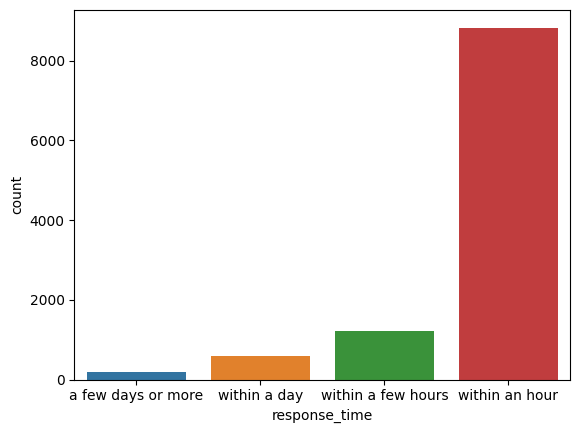

In [627]:
sns.countplot(data=df.sort_values('response_time'), x='response_time', )

- Response rate  
Changing datatype to int  
Temporarily sort by ascending values for visualization

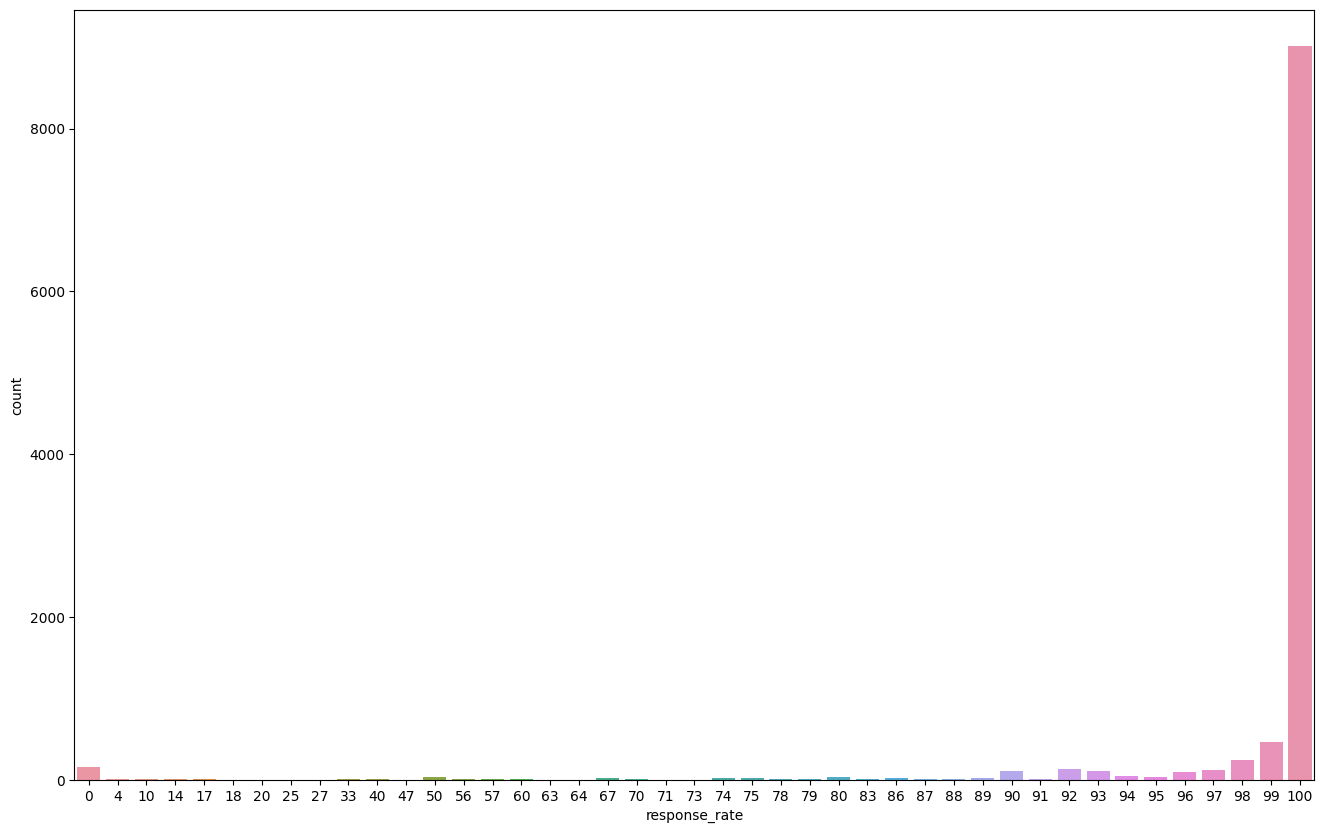

In [628]:
df['response_rate'] = df['response_rate'].astype(int)
g = sns.countplot(data=df.sort_values('response_rate'), x= 'response_rate', )
g.figure.set_size_inches(16, 10)


- Superhostness  

<AxesSubplot:xlabel='is_superhost', ylabel='count'>

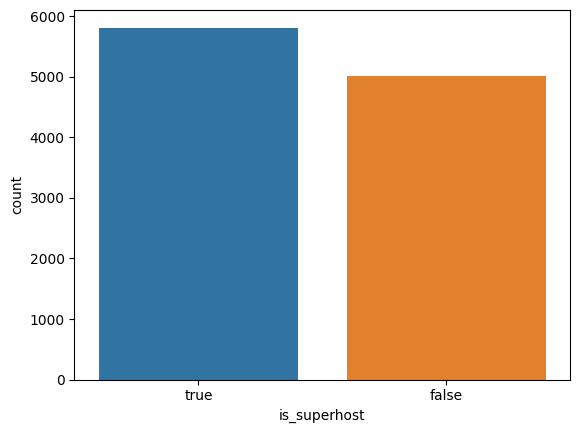

In [629]:
sns.countplot(data=df, x ='is_superhost',  )

##### Conclusions from visualizations  
We can see that the vast majority of hosts:
- responses within an hour.  
- responses to all all messages.    
**but** being superhost is somewhat equally distributed.  

Distribution in numbers:

In [630]:
bold = "\033[1m"
reset = "\033[0m"
print(f"{bold}Response time:{reset} \n{df['response_time'].value_counts()}\n")
print(f"{bold}Response rate:{reset} \n{df['response_rate'].value_counts()}\n")
print(f"{bold}Superhostness: {reset}\n{df['is_superhost'].value_counts()}")

Response time: 
within an hour        8828
within a few hours    1216
within a day           579
a few days or more     193
Name: response_time, dtype: int64

Response rate: 
100    9009
99      460
98      237
0       161
92      130
97      115
93      113
90      103
96       93
94       42
80       37
50       34
95       30
89       26
75       24
74       22
67       19
86       19
70       15
88       15
83       13
91       13
87       12
60       11
57       10
33        7
78        6
79        5
4         5
56        5
10        3
40        3
14        3
17        3
27        2
20        2
25        2
71        2
47        1
63        1
64        1
73        1
18        1
Name: response_rate, dtype: int64

Superhostness: 
true     5810
false    5006
Name: is_superhost, dtype: int64


##### Using pivot for inspection  
From here we can see that the mean response_rate among supershosts and not-superhosts are not too far off of each other.    

In [631]:
pivot_table = df.pivot_table(values='response_rate', index=['response_time', 'is_superhost'], aggfunc='mean')
print(pivot_table)

                                 response_rate
response_time      is_superhost               
a few days or more false              3.507853
                   true              16.500000
within a day       false             90.899533
                   true              96.225166
within a few hours false             96.398611
                   true              98.689516
within an hour     false             98.988274
                   true              99.826390


Convert response_times to numbers.  

In [632]:
df.replace({'within an hour':4, 'within a few hours': 3, 'within a day': 2, 'a few days or more': 1}, inplace=True)
df.head()

,response_time,response_rate,is_superhost
0,3,100,true
2,2,100,true
3,4,100,true
4,2,90,false
5,4,100,true


### Trying out classifiers  
##### KNN

In [633]:
# Feature and target separation
X = df[['response_time', 'response_rate']]
y = df['is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initiation and training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)       # training the model

# Predict and evaluate
y_prediction = knn.predict(X_test)
acc = accuracy_score(y_test, y_prediction)

print(f"KNN accuracy: {acc:.2f}")

KNN accuracy: 0.69


##### Logistic regression

In [634]:
# Feature and target separation
X = df[['response_time', 'response_rate']]
y = df['is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

# Model initiation and training
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.65


##### Random Forest Classifier

In [635]:
# Feature and target separation
X = df[['response_time', 'response_rate']]
y = df['is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initiation and training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

Random Forest Accuracy: 0.69


##### Support Vector Machine (SVM)

In [ ]:
# Feature and target separation
X = df[['response_time', 'response_rate']]
y = df['is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Model initiation and training
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict and evaluate
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

print(f"SVM Accuracy: {svm_accuracy:.2f}")

SVM Accuracy: 0.62


#### Conclusions from classifiers
As we suspected looking at the pivot table earlier, response_time and response_rate don't do a good job predicting wheter host is superhost or not. K-NearestNeighbors and Random Forest Classifier seem to achieve the best results, but even those prediction are just under 70%.  